# Overview

In this notebook, we walk through all the necessary components of running experiments on LIBERO, and some common usage such as defining your own algorithm and policy architectures in the codebase.

1. Dataset preparation for your algorithms
2. Write your own algorithm
    - Subclassing from `Sequential` base class
3. Write your own model
4. Write your training loop
5. Visualize results

## 1. Experiments

In [149]:
from hydra import compose, initialize

from libero.libero import get_libero_path
import hydra
import pprint
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['PYOPENGL_PLATFORM'] = 'egl'
from omegaconf import OmegaConf
import yaml
from easydict import EasyDict
from libero.libero.benchmark import get_benchmark
from libero.lifelong.datasets import (GroupedTaskDataset, SequenceVLDataset, get_dataset)
from libero.lifelong.utils import (get_task_embs, safe_device, create_experiment_dir)
hydra.core.global_hydra.GlobalHydra.instance().clear()

### load the default hydra config
initialize(config_path="../libero/configs")
hydra_cfg = compose(config_name="config")
yaml_config = OmegaConf.to_yaml(hydra_cfg)
cfg = EasyDict(yaml.safe_load(yaml_config))

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(cfg.policy)
pp.pprint(cfg.data)

# prepare lifelong learning
cfg.folder = get_libero_path("datasets")
cfg.bddl_folder = get_libero_path("bddl_files")
cfg.init_states_folder = get_libero_path("init_states")
cfg.eval.num_procs = 1
cfg.eval.n_eval = 5

cfg.train.n_epochs = 25

pp.pprint(f"Note that the number of epochs used in this example is intentionally reduced to 5.")

task_order = cfg.data.task_order_index # can be from {0 .. 21}, default to 0, which is [task 0, 1, 2 ...]
cfg.benchmark_name = "libero_object" # can be from {"libero_spatial", "libero_object", "libero_goal", "libero_10"}
benchmark = get_benchmark(cfg.benchmark_name)(task_order)

# prepare datasets from the benchmark
datasets = []
descriptions = []
shape_meta = None
n_tasks = benchmark.n_tasks
cfg.data.seq_len = 64


for i in range(n_tasks):
    # currently we assume tasks from same benchmark have the same shape_meta
    task_i_dataset, shape_meta = get_dataset(
            dataset_path=os.path.join(cfg.folder, benchmark.get_task_demonstration(i)),
            obs_modality=cfg.data.obs.modality,
            initialize_obs_utils=(i==0),
            seq_len=cfg.data.seq_len, 
        # Question: does this truncate or simply segment? if segment, how do you know if sample is end?
        # Answer: you don't, in many of these tasks it seems like they don't care, weirdly
    )
    # add language to the vision dataset, hence we call vl_dataset
    descriptions.append(benchmark.get_task(i).language)
    datasets.append(task_i_dataset)

task_embs = get_task_embs(cfg, descriptions)
benchmark.set_task_embs(task_embs)

datasets = [SequenceVLDataset(ds, emb) for (ds, emb) in zip(datasets, task_embs)]
n_demos = [data.n_demos for data in datasets]
n_sequences = [data.total_num_sequences for data in datasets]

/tmp/ipykernel_444945/2226875101.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../libero/configs")


{ 'color_aug': { 'network': 'BatchWiseImgColorJitterAug',
                 'network_kwargs': { 'brightness': 0.3,
                                     'contrast': 0.3,
                                     'epsilon': 0.1,
                                     'hue': 0.3,
                                     'input_shape': None,
                                     'saturation': 0.3}},
  'embed_size': 64,
  'extra_hidden_size': 128,
  'extra_num_layers': 0,
  'image_encoder': { 'network': 'ResnetEncoder',
                     'network_kwargs': { 'freeze': False,
                                         'language_fusion': 'film',
                                         'no_stride': False,
                                         'pretrained': False,
                                         'remove_layer_num': 4}},
  'language_encoder': { 'network': 'MLPEncoder',
                        'network_kwargs': { 'hidden_size': 128,
                                            'input_size': 768,
 

In [232]:
sample = datasets[0].__getitem__(0)
pp.pprint(cfg.task_embedding_format)


'bert'


In [ ]:
print(sample.keys())
print(sample['obs'].keys())
print(sample['task_emb'].shape)
print(sample['obs']['agentview_rgb'].shape)
for act in sample['obs']['agentview_rgb']: #sample['actions']:
    print(act.mean())

In [184]:
import numpy as np
import matplotlib.pyplot as plt

def gallery(array, ncols=1):
    nindex, intensity, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    # result = (array.reshape(nrows, ncols, height, width, intensity)
    #           .swapaxes(1,2)
    #           .reshape(height*nrows, width*ncols, intensity))
    # result = array.reshape(height*nrows, width*ncols, intensity)
    result = array.swapaxes(2,0)
    return result

def tile(arr, nrows=8, ncols=8):
    """
    Args:
        arr: HWC format array
        nrows: number of tiled rows
        ncols: number of tiled columns
    """
    im, c, h, w = arr.shape
    out_height = nrows * h
    out_width = ncols * w
    chw = np.moveaxis(arr, (0, 1, 2), (1, 2, 0))

    if c < nrows * ncols:
        chw = chw.reshape(-1).copy()
        chw.resize(nrows * ncols * h * w)

    return (chw
        .reshape(nrows, ncols, h, w)
        .swapaxes(1, 2)
        .reshape(out_height, out_width))



(64, 3, 128, 128)
(8, 8, 3, 128, 128)
(8, 8, 128, 128, 3)
(8, 1024, 128, 3)


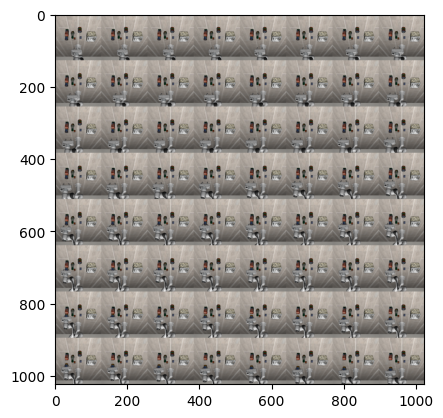

In [231]:
# result = gallery(np.expand_dims(sample['obs']['agentview_rgb'][0],axis=0))
orig_shape = sample['obs']['agentview_rgb'].shape
print(orig_shape)
# combined_arr = []
# print(np.sqrt(orig_shape[0]))
# nrows = int(np.sqrt(orig_shape[0]))
# ncols = orig_shape[0]//nrows
# for i in range(nrows):
#     temp=[]
#     for j in range(ncols):
#         temp.append(sample['obs']['agentview_rgb'][i*ncols+j])
#     combined_arr.append(temp)
    
    
# Distribute the first dimension to 8x8x3x128x128:
arr1 = sample['obs']['agentview_rgb'].reshape(8,8,*orig_shape[1:], order='F')
print(arr1.shape)
arr2 = np.moveaxis(arr1,2,-1)
print(arr2.shape)
arr3 = arr2.reshape(8,8*128,128,3, order='A')
print(arr3.shape)
arr4 = arr3.swapaxes(1,2).reshape(8*128,8*128,3).swapaxes(0,1)
# result = np.moveaxis(sample['obs']['agentview_rgb'],1, -1) #. reshape(8*128,8*128,3, order='A')
plt.imshow(arr4)
plt.show()
# plt.imsave('sample0.png',result)


## Try to put the data into a rollout buffer instead

In [116]:
import sheeprl
import os

os.environ["MUJOCO_GL"] = "egl"

import copy
import pathlib

import gymnasium as gym
import numpy as np
import torch
import torchvision
from torchvision.transforms import v2
from lightning.fabric import Fabric
from omegaconf import OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from PIL import Image

from sheeprl.algos.dreamer_v3.agent import build_agent
from sheeprl.data.buffers import SequentialReplayBuffer
from sheeprl.utils.env import make_env
from sheeprl.utils.utils import dotdict
from torch.utils.data import DataLoader, RandomSampler


In [117]:
# path of your checkpoint
# ckpt_path = pathlib.Path("/path/to/your/checkpoint.ckpt")

### Should be unnecessary
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
###

with hydra.initialize(version_base="1.3", config_path="../../sheeprl/sheeprl/configs"):
    cfg = hydra.compose(
        config_name="config.yaml",
        overrides=[
            "exp=dreamer_v3",
            "env=dmc",
            "env.wrapper.domain_name=walker",
            "env.wrapper.task_name=walk",
        ],
    )
    cfg = dotdict(OmegaConf.to_container(cfg, resolve=True, throw_on_missing=True))
    print(cfg)
# sheeprl.cli.check_configs(cfg)  # TODO balloch: there should be some way to make this work, but im not sure how
# run_algorithm(cfg)

torch.set_float32_matmul_precision('medium')
seed = 5
fabric = Fabric(accelerator="cuda", devices=1)
fabric.launch()
# state = fabric.load(ckpt_path)

# The number of environments is set to 1
cfg.env.num_envs = 1

{'num_threads': 1, 'float32_matmul_precision': 'high', 'dry_run': False, 'seed': 42, 'torch_use_deterministic_algorithms': False, 'torch_backends_cudnn_benchmark': True, 'torch_backends_cudnn_deterministic': False, 'cublas_workspace_config': None, 'exp_name': 'dreamer_v3_walker_walk', 'run_name': '2024-06-02_19-01-38_dreamer_v3_walker_walk_42', 'root_dir': 'dreamer_v3/walker_walk', 'algo': {'name': 'dreamer_v3', 'total_steps': 5000000, 'per_rank_batch_size': 16, 'run_test': True, 'cnn_keys': {'encoder': ['rgb'], 'decoder': ['rgb']}, 'mlp_keys': {'encoder': [], 'decoder': []}, 'world_model': {'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 0.0001, 'eps': 1e-08, 'weight_decay': 0, 'betas': [0.9, 0.999]}, 'discrete_size': 32, 'stochastic_size': 32, 'kl_dynamic': 0.5, 'kl_representation': 0.1, 'kl_free_nats': 1.0, 'kl_regularizer': 1.0, 'continue_scale_factor': 1.0, 'clip_gradients': 1000.0, 'decoupled_rssm': False, 'learnable_initial_recurrent_state': True, 'encoder': {'cnn_channels_m

In [118]:
### Setup Env and Agent

# NOTE Right now env is MuJoCo walker, needs to become is Robosuite
envs = gym.vector.SyncVectorEnv(
    [
        make_env(
            cfg,
            cfg.seed + 0 * cfg.env.num_envs + i,
            0 * cfg.env.num_envs,
            "./imagination",
            "imagination",
            vector_env_idx=i,
        )
        for i in range(cfg.env.num_envs)
    ]
)
action_space = envs.single_action_space  # TODO overwrite for test
observation_space = envs.single_observation_space
obs_keys = cfg.algo.cnn_keys.encoder + cfg.algo.mlp_keys.encoder


is_continuous = isinstance(action_space, gym.spaces.Box)
is_multidiscrete = isinstance(action_space, gym.spaces.MultiDiscrete)
actions_dim = tuple(
    action_space.shape if is_continuous else (action_space.nvec.tolist() if is_multidiscrete else [action_space.n])
)
world_model, actor, critic, critic_target, player = build_agent(
    fabric,
    actions_dim,
    is_continuous,
    cfg,
    observation_space,
    None, #state["world_model"]
    None, #state["actor"],
    None, #state["critic"],
    None, #state["target_critic"],
)

In [132]:
####### BUFFER INITIALIZATION
initial_steps = 10  # set according to your environment.
imagination_steps = 5  # number of imagination steps, must be lower than or equal to the `initial_steps`.

rb_initial = SequentialReplayBuffer(initial_steps, cfg.env.num_envs)
rb_play = SequentialReplayBuffer(imagination_steps, cfg.env.num_envs)
rb_imagination = SequentialReplayBuffer(imagination_steps, cfg.env.num_envs)


###### Agent and env initialization
clip_rewards_fn = lambda r: torch.tanh(r) if cfg.env.clip_rewards else r
step_data = {}
player.init_states()
obs = envs.reset(seed=cfg.seed)[0]


# >>> ds = MyIterableDataset(start=3, end=7)
# >>> def worker_init_fn(worker_id):
# ...     worker_info = torch.utils.data.get_worker_info()
# ...     dataset = worker_info.dataset  # the dataset copy in this worker process
# ...     overall_start = dataset.start
# ...     overall_end = dataset.end
# ...     # configure the dataset to only process the split workload
# ...     per_worker = int(math.ceil((overall_end - overall_start) / float(worker_info.num_workers)))
# ...     worker_id = worker_info.id
# ...     dataset.start = overall_start + worker_id * per_worker
# ...     dataset.end = min(dataset.start + per_worker, overall_end)
# >>> # Mult-process loading with the custom `worker_init_fn`
# >>> # Worker 0 fetched [3, 4].  Worker 1 fetched [5, 6].
# >>> print(list(torch.utils.data.DataLoader(ds, num_workers=2, worker_init_fn=worker_init_fn)))

### Dataset and loader

train_dataloader = DataLoader(
    datasets[0],
    batch_size=1, #cfg.train.batch_size,
    num_workers=4, #cfg.train.num_workers,
    sampler=RandomSampler(datasets[0]),
    persistent_workers=True,
)
# torchvision.transforms.v2.functional.resize
transforms = v2.Compose([
    v2.Resize(size=(64,64))
])


In [110]:
print(step_data.keys()) #NOTE no state because of cfg
print(obs.keys())

dict_keys([])
odict_keys(['rgb', 'state'])


In [111]:
# import inspect
print(sample.keys())
print(sample['actions'].shape)
print(obs.keys()) 
print('libero_actions: ', sample['actions'].shape)
for thing in (sample['obs'], obs):
    for ok, ov in thing.items():
        try:
            print(ok, "; ", ov.shape)
        except:
            print(f'Not tensor. {ok} is , {type(ov)}')
# obs['rgb'].shape
# type(sample['obs'])
# sample['obs'].keys()
# print(inspect.getbases(envs))
# type(envs).__mro__

dict_keys(['actions', 'obs', 'task_emb'])
(10, 7)
odict_keys(['rgb', 'state'])
libero_actions:  (10, 7)
agentview_rgb ;  (10, 3, 128, 128)
eye_in_hand_rgb ;  (10, 3, 128, 128)
gripper_states ;  (10, 2)
joint_states ;  (10, 7)
rgb ;  (1, 3, 64, 64)
state ;  (1, 24)


In [127]:
import torch.nn.functional as F

import pdb


def process_obs(obs):
    preprocessed_obs = {}
    for k, v in obs.items():
        vtensor = torch.as_tensor(v[np.newaxis], dtype=torch.float32, device=fabric.device)
        # shape = list(v.squeeze().shape)
        # if len(shape)>2 and shape[-1] == 128:
        #     print("transformed!")
        #     shape[-2:] = shape[-2]//2,shape[-1]//2
        #     preprocessed_obs[k] = F.interpolate(
        #         input=vtensor,
        #         size=shape,
        #         mode="area",
        #     )
        # else:
        preprocessed_obs[k] = vtensor
        if k in cfg.algo.cnn_keys.encoder:
            preprocessed_obs[k] = preprocessed_obs[k] / 255.0 - 0.5
    return preprocessed_obs

def get_actions(player, obs, mask):
    real_actions = actions = player.get_actions(obs, mask=mask)
    # pdb.set_trace()
    actions = torch.cat(actions, -1).cpu().numpy()  # <--- I think this just turns the tuple of tensor in cpu np? cat does nothing?
    if is_continuous:
        real_actions = torch.stack(real_actions, dim=-1).cpu().numpy()
    else:
        real_actions = torch.stack([real_act.argmax(dim=-1) for real_act in real_actions], dim=-1).cpu().numpy()
    return actions, real_actions

def libero2dreamer_obs(next_sample,i,shape_dict=None):
    # pdb.set_trace()
    fake_obs = {'rgb': torch.select(data['obs']['agentview_rgb'],1,i).cpu().numpy()}
    # if shape_dict:
    #     # for k,v in fake_obs.items():
    #     k = 'rgb'
    #     shape = list(shape_dict[k])
    #     if len(shape)>2 and shape[-1] == 128:
    #         # shape[-2:] = shape[-2]//2,shape[-1]//2
    #         fake_obs[k] = np.interp(
    #             input=vtensor,
    #             size=shape,
    #             mode="area",
    #         )
    #         # fake_obs[k] = F.interpolate(
    #         #     input=vtensor,
    #         #     size=shape,
    #         #     mode="area",
    #         # )

    # FROM:
    # dict_keys(['actions', 'obs', 'task_emb'])
    # dict_keys(['agentview_rgb', 'eye_in_hand_rgb', 'gripper_states', 'joint_states'])
    # TO: 
    # dict_keys(['rgb','state'])
    # Shapes: [(1, 3, 64, 64), (1, 24)]
    # Final:
    # dict_keys(['rgb', 'dones', 'rewards', 'is_first', 'stochastic_state', 'recurrent_state', 'actions'])
    return fake_obs

def get_actions_from_data(dataset_sample ,i,orig_shape=None):
    # torch.as_tensor(sample['actions'][0,:actions[0].shape[-1]], dtype=torch.float32, device=fabric.device).view(actions[0].shape)
    fake_real_actions = fake_actions =  torch.select(dataset_sample['actions'][:,:,:-1],-2,i).view(orig_shape).cpu().numpy()
    ## NOTE: looks like float 64 not 32, could cause a problem
    # fake_actions = torch.cat(fake_actions, -1).cpu().numpy()
    # if is_continuous:
    #     fake_real_actions = torch.stack(fake_real_actions, dim=-1).cpu().numpy()
    # else:
    #     # Note: current impl doesn't cover this, ignoring for now
    #     fake_real_actions = torch.stack([real_act.argmax(dim=-1) for real_act in fake_real_actions], dim=-1).cpu().numpy()
    return fake_actions, fake_real_actions


In [113]:
# shape = list(obs['rgb'].shape)
# shape[-2:] = shape[-2]//2,shape[-1]//2
# print(shape)
print([ v.shape for k,v in obs.items()])

[(1, 3, 64, 64), (1, 24)]


In [138]:
#### Fill buffers
info_list = []
from_dataset = True
# play for `initial_steps` steps
                # for (idx, data) in enumerate(train_dataloader):
                #     loss = self.observe(data)
                #     training_loss += loss

for (o_idx, data) in enumerate(train_dataloader):
    # Initial observation and action
    step_data["dones"] = np.zeros((1, cfg.env.num_envs, 1))
    step_data["rewards"] = np.zeros((1, cfg.env.num_envs, 1))
    step_data["is_first"] = np.ones_like(step_data["dones"])
    if from_dataset: 
        # data['obs']['agentview_rgb'] = transforms(data['obs']['agentview_rgb'])
        data['obs']['agentview_rgb'] = torchvision.transforms.v2.functional.resize(data['obs']['agentview_rgb'],size=(64,64))
        shape_dict = {'rgb':(1, 3, 64, 64)}
        obs = libero2dreamer_obs(data,0,shape_dict)
        
    # pdb.set_trace()
    for k in obs_keys:
        step_data[k] = obs[k][np.newaxis]
    
    for i in range(initial_steps):

        with torch.no_grad():
            preprocessed_obs = process_obs(obs)
            mask = {k: v for k, v in preprocessed_obs.items() if k.startswith("mask")}
            if len(mask) == 0:
                mask = None
            # pdb.set_trace()
            player_actions, player_real_actions = get_actions(player, preprocessed_obs, mask) 
        ###
        ### This is where our stuff is inserted.
        ###
            #we can continue to use this instead of random states, but need to call to player to update internal state
            if from_dataset:
                # Question: what are the actions in the last frame in a sequence? Nones?
                # currently this will not really make any use of the "final action" and i think thats fine
                actions, real_actions = get_actions_from_data(data,i,orig_shape=player_actions.shape)
            else:
                actions, real_actions = player_actions, player_real_actions
        
        step_data["stochastic_state"] = player.stochastic_state.detach().cpu().numpy()
        step_data["recurrent_state"] = player.recurrent_state.detach().cpu().numpy()
        step_data["actions"] = actions.reshape((1, cfg.env.num_envs, -1))
        # print([(key,type(datum)) for key, datum in step_data.items()])
        # try:
        # pdb.set_trace()
        rb_initial.add(step_data, validate_args=cfg.buffer.validate_args)
        # except:
        #     pdb.set_trace()

        if from_dataset:
            if i == initial_steps-1:
                continue
            else:
                # all logic here should correspond to i+1
                # if its the initial step, just add it straight to the replay buffer and set up next run (before this)
                # if its the LAST step, add to the replay buffer and reset everything
                # else: reset everything
                truncated = np.zeros((1, cfg.env.num_envs, 1))
                infos = {'discount': np.array([1.]), '_discount': np.array([ True])}
                next_obs = libero2dreamer_obs(data,i+1,shape_dict)
                if i == initial_steps-2:
                    rewards = np.ones((1, cfg.env.num_envs, 1))
                    dones = np.ones((1, cfg.env.num_envs, 1))
                    # list(np.squeeze(next_obs))
                    infos['final_observation'] = [next_obs]
                    # pdb.set_trace()
                else:
                    rewards = np.zeros((1, cfg.env.num_envs, 1))
                    dones = np.zeros((1, cfg.env.num_envs, 1))
        ###
        ### This is where it ends pretty much.
        ###
    
        else:
            # Replacate this behavior in dataset sampling:
            next_obs, rewards, dones, truncated, infos = envs.step(real_actions.reshape(envs.action_space.shape))
            if len(dones.nonzero()[0].tolist()) >0:
                pdb.set_trace()
            
            rewards = np.array(rewards).reshape((1, cfg.env.num_envs, -1))
            dones = np.logical_or(dones, truncated).astype(np.uint8).reshape((1, cfg.env.num_envs, -1))
    
        step_data["is_first"] = np.zeros_like(step_data["dones"])
        if "restart_on_exception" in infos:
            for i, agent_roe in enumerate(infos["restart_on_exception"]):
                if agent_roe and not dones[i]:
                    last_inserted_idx = (rb_initial.buffer[i]._pos - 1) % rb_initial.buffer[i].buffer_size
                    rb_initial.buffer[i]["dones"][last_inserted_idx] = np.ones_like(
                        rb_initial.buffer[i]["dones"][last_inserted_idx]
                    )
                    rb_initial.buffer[i]["is_first"][last_inserted_idx] = np.zeros_like(
                        rb_initial.buffer[i]["is_first"][last_inserted_idx]
                    )
                    step_data["is_first"][i] = np.ones_like(step_data["is_first"][i])
    
        real_next_obs = copy.deepcopy(next_obs)
        if "final_observation" in infos:
            # pdb.set_trace()
            for idx, final_obs in enumerate(infos["final_observation"]):
                if final_obs is not None:
                    for k, v in final_obs.items():
                        real_next_obs[k][idx] = v
    
        for k in obs_keys:
            step_data[k] = next_obs[k][np.newaxis]
    
        obs = next_obs
    
        rewards = rewards.reshape((1, cfg.env.num_envs, -1)) # TODO I believe this is redundant
    
        
        step_data["dones"] = dones.reshape((1, cfg.env.num_envs, -1))
        step_data["rewards"] = clip_rewards_fn(rewards)
        dones_idxes = dones.nonzero()[0].tolist()
        reset_envs = len(dones_idxes)
        if reset_envs > 0:
            reset_data = {}
            for k in obs_keys:
                reset_data[k] = (real_next_obs[k][dones_idxes])[np.newaxis]
            reset_data["dones"] = np.ones((1, reset_envs, 1))
            reset_data["actions"] = np.zeros((1, reset_envs, np.sum(actions_dim)))
            reset_data["rewards"] = step_data["rewards"][:, dones_idxes]
            reset_data["is_first"] = np.zeros_like(reset_data["dones"])
            try:
                # rb_initial.add(reset_data, dones_idxes, validate_args=cfg.buffer.validate_args)
                rb_initial.add(reset_data, validate_args=cfg.buffer.validate_args)
            except:
                pdb.set_trace()
    
            # Reset already inserted step data
            step_data["rewards"][:, dones_idxes] = np.zeros_like(reset_data["rewards"])
            step_data["dones"][:, dones_idxes] = np.zeros_like(step_data["dones"][:, dones_idxes])
            step_data["is_first"][:, dones_idxes] = np.ones_like(step_data["is_first"][:, dones_idxes])
            player.init_states(dones_idxes)
    
        ## Save the recurrent and stochastic latent states for the imagination phase
        if i == initial_steps - imagination_steps:
            stochastic_state = player.stochastic_state.clone()
            recurrent_state = player.recurrent_state.clone()

In [139]:
rb_sample = rb_initial.sample(
    batch_size=2,
    sequence_length=4,
)
print(len(rb_initial))

10


In [140]:
# type(rb_sample)
print(rb_sample.keys())
print([ v.shape for k,v in rb_sample.items()])
rb_sample['rgb'].shape

dict_keys(['dones', 'rewards', 'is_first', 'rgb', 'stochastic_state', 'recurrent_state', 'actions'])
[(1, 4, 2, 1), (1, 4, 2, 1), (1, 4, 2, 1), (1, 4, 2, 3, 64, 64), (1, 4, 2, 1024), (1, 4, 2, 512), (1, 4, 2, 6)]


(1, 4, 2, 3, 64, 64)

In [78]:
from collections.abc import Sequence

def recurse_seq_find(seq, string):
    for item in seq:
        if 'batch' in item:
            print(f'{item}')
        elif isinstance(item, dict):
            recurse_dict_find(item,string)
        elif isinstance(item,Sequence):
            recurse_seq_find(item, string)
        else:
            print(f'Type is {type(item)}')    

def recurse_dict_find(dic,string):
    for kconf,vconf in dic.items():
        if 'batch' in kconf:
            print(f'{kconf}: {vconf}')
        elif isinstance(vconf,dict):
            recurse_dict_find(vconf,string)
        # elif isinstance(vconf,Sequence):
        #     recurse_seq_find(vconf, string)
        # else:
        #     print(f'Type is {type(vconf)}')
recurse_dict_find(cfg, 'batch')

# for kconf,vconf in cfg.items():
#     # if 'batch' in kconf:
#     print(f'{kconf}: {type(vconf)}')

per_rank_batch_size: 16


In [142]:
temp = 123
print(rb_sample.keys())


dict_keys(['dones', 'rewards', 'is_first', 'rgb', 'stochastic_state', 'recurrent_state', 'actions'])


In [144]:
# Imagination and Reconstruction
imagine_actions = True

# imagination / reconstruction obs process
imagined_latent_states = torch.cat((stochastic_state, recurrent_state), -1)
step_data = {}
reconstruced_step_data = {}
with torch.no_grad():
    for i in range(imagination_steps):
        if imagine_actions:
            # imagined actions
            actions = actor(imagined_latent_states.detach())[0][0]
        else:
            # actions actually played by the agent
            actions = torch.tensor(
                rb_initial["actions"][-imagination_steps + i],
                device=fabric.device,
                dtype=torch.float32,
            )[None]

        # imagination step
        stochastic_state, recurrent_state = world_model.rssm.imagination(stochastic_state, recurrent_state, actions)
        stochastic_state = stochastic_state.view(1, 1, -1)
        # update current state
        imagined_latent_states = torch.cat((stochastic_state, recurrent_state), -1)
        rec_obs = world_model.observation_model(imagined_latent_states)
        step_data["rgb"] = rec_obs["rgb"].unsqueeze(0).detach().cpu().numpy() + 0.5
        step_data["actions"] = actions.unsqueeze(0).detach().cpu().numpy()
        rb_imagination.add(step_data)

        # reconstruct the observations from the latent states used when interacting with the environment
        played_latent_states = torch.cat(
            (
                torch.tensor(rb_initial["stochastic_state"][-imagination_steps + i], device=fabric.device),
                torch.tensor(rb_initial["recurrent_state"][-imagination_steps + i], device=fabric.device),
            ),
            -1,
        )
        rec_obs_played = world_model.observation_model(played_latent_states)
        # The decoder has been trained to reconstruct the observations from the latent states in the range [-0.5, 0.5]
        # NOTE: Check how the observations are handled in older versions of SheepRL (before 0.5.5)
        # if you need to add 0.5 or not (in latest versions it is done automatically by the decoder in its forward method).
        reconstruced_step_data["rgb"] = rec_obs_played["rgb"].unsqueeze(0).detach().cpu().numpy() + 0.5
        rb_play.add(reconstruced_step_data)

In [146]:
# GIF Creation

# create a gif with the imagined frames (the latent state is computed by the transition model)
frames_imag = torch.clamp(torch.tensor(rb_imagination["rgb"][:, 0, 0]), 0, 1).detach()
frames_imag = [torchvision.transforms.functional.to_pil_image(f) for f in frames_imag]
frame_one_imag = frames_imag[0]
frame_one_imag.save("imagination.gif", format="GIF", append_images=frames_imag, save_all=True, duration=100, loop=0)

# create a gif with the reconstructed observations (the latent state is computed by the representation model)
frames_recon = torch.clamp(torch.tensor(rb_play["rgb"][:, 0]), 0, 1).detach()
frames_recon = [torchvision.transforms.functional.to_pil_image(f) for f in frames_recon]
frame_one_recon = frames_recon[0]
frame_one_recon.save("reconstructed_obs.gif", format="GIF", append_images=frames_recon, save_all=True, duration=100, loop=0)

# create a gif with the real observations (provided by the environment)
frames_real = torch.tensor(rb_initial["rgb"][-imagination_steps:, 0])
frames_real = [torchvision.transforms.functional.to_pil_image(f) for f in frames_real]
frame_one_real = frames_real[0]
frame_one_real.save("real_obs.gif", format="GIF", append_images=frames_real, save_all=True, duration=100, loop=0)

### 2. Write your own policy architecture

In [4]:
import robomimic.utils.tensor_utils as TensorUtils
import torch
import torch.nn as nn

from einops import rearrange, repeat
from libero.lifelong.models.modules.rgb_modules import *
from libero.lifelong.models.modules.language_modules import *
from libero.lifelong.models.base_policy import BasePolicy
from libero.lifelong.models.policy_head import *
from libero.lifelong.models.modules.transformer_modules import *

###############################################################################
#
# A model handling extra input modalities besides images at time t.
#
###############################################################################

class ExtraModalityTokens(nn.Module):
    def __init__(
        self,
        use_joint=False,
        use_gripper=False,
        use_ee=False,
        extra_num_layers=0,
        extra_hidden_size=64,
        extra_embedding_size=32,
    ):
        """
        This is a class that maps all extra modality inputs into tokens of the same size
        """
        super().__init__()
        self.use_joint = use_joint
        self.use_gripper = use_gripper
        self.use_ee = use_ee
        self.extra_embedding_size = extra_embedding_size

        joint_states_dim = 7
        gripper_states_dim = 2
        ee_dim = 3

        self.num_extra = int(use_joint) + int(use_gripper) + int(use_ee)

        extra_low_level_feature_dim = (
            int(use_joint) * joint_states_dim
            + int(use_gripper) * gripper_states_dim
            + int(use_ee) * ee_dim
        )

        assert extra_low_level_feature_dim > 0, "[error] no extra information"

        self.extra_encoders = {}

        def generate_proprio_mlp_fn(modality_name, extra_low_level_feature_dim):
            assert extra_low_level_feature_dim > 0  # we indeed have extra information
            if extra_num_layers > 0:
                layers = [nn.Linear(extra_low_level_feature_dim, extra_hidden_size)]
                for i in range(1, extra_num_layers):
                    layers += [
                        nn.Linear(extra_hidden_size, extra_hidden_size),
                        nn.ReLU(inplace=True),
                    ]
                layers += [nn.Linear(extra_hidden_size, extra_embedding_size)]
            else:
                layers = [nn.Linear(extra_low_level_feature_dim, extra_embedding_size)]

            self.proprio_mlp = nn.Sequential(*layers)
            self.extra_encoders[modality_name] = {"encoder": self.proprio_mlp}

        for (proprio_dim, use_modality, modality_name) in [
            (joint_states_dim, self.use_joint, "joint_states"),
            (gripper_states_dim, self.use_gripper, "gripper_states"),
            (ee_dim, self.use_ee, "ee_states"),
        ]:

            if use_modality:
                generate_proprio_mlp_fn(modality_name, proprio_dim)

        self.encoders = nn.ModuleList(
            [x["encoder"] for x in self.extra_encoders.values()]
        )

    def forward(self, obs_dict):
        """
        obs_dict: {
            (optional) joint_stats: (B, T, 7),
            (optional) gripper_states: (B, T, 2),
            (optional) ee: (B, T, 3)
        }
        map above to a latent vector of shape (B, T, H)
        """
        tensor_list = []

        for (use_modality, modality_name) in [
            (self.use_joint, "joint_states"),
            (self.use_gripper, "gripper_states"),
            (self.use_ee, "ee_states"),
        ]:

            if use_modality:
                tensor_list.append(
                    self.extra_encoders[modality_name]["encoder"](
                        obs_dict[modality_name]
                    )
                )

        x = torch.stack(tensor_list, dim=-2)
        return x

###############################################################################
#
# A Transformer policy
#
###############################################################################


class MyTransformerPolicy(BasePolicy):
    """
    Input: (o_{t-H}, ... , o_t)
    Output: a_t or distribution of a_t
    """

    def __init__(self, cfg, shape_meta):
        super().__init__(cfg, shape_meta)
        policy_cfg = cfg.policy

        ### 1. encode image
        embed_size = policy_cfg.embed_size
        transformer_input_sizes = []
        self.image_encoders = {}
        for name in shape_meta["all_shapes"].keys():
            if "rgb" in name or "depth" in name:
                kwargs = policy_cfg.image_encoder.network_kwargs
                kwargs.input_shape = shape_meta["all_shapes"][name]
                kwargs.output_size = embed_size
                kwargs.language_dim = (
                    policy_cfg.language_encoder.network_kwargs.input_size
                )
                self.image_encoders[name] = {
                    "input_shape": shape_meta["all_shapes"][name],
                    "encoder": eval(policy_cfg.image_encoder.network)(**kwargs),
                }

        self.encoders = nn.ModuleList(
            [x["encoder"] for x in self.image_encoders.values()]
        )

        ### 2. encode language
        policy_cfg.language_encoder.network_kwargs.output_size = embed_size
        self.language_encoder = eval(policy_cfg.language_encoder.network)(
            **policy_cfg.language_encoder.network_kwargs
        )

        ### 3. encode extra information (e.g. gripper, joint_state)
        self.extra_encoder = ExtraModalityTokens(
            use_joint=cfg.data.use_joint,
            use_gripper=cfg.data.use_gripper,
            use_ee=cfg.data.use_ee,
            extra_num_layers=policy_cfg.extra_num_layers,
            extra_hidden_size=policy_cfg.extra_hidden_size,
            extra_embedding_size=embed_size,
        )

        ### 4. define temporal transformer
        policy_cfg.temporal_position_encoding.network_kwargs.input_size = embed_size
        self.temporal_position_encoding_fn = eval(
            policy_cfg.temporal_position_encoding.network
        )(**policy_cfg.temporal_position_encoding.network_kwargs)

        self.temporal_transformer = TransformerDecoder(
            input_size=embed_size,
            num_layers=policy_cfg.transformer_num_layers,
            num_heads=policy_cfg.transformer_num_heads,
            head_output_size=policy_cfg.transformer_head_output_size,
            mlp_hidden_size=policy_cfg.transformer_mlp_hidden_size,
            dropout=policy_cfg.transformer_dropout,
        )

        policy_head_kwargs = policy_cfg.policy_head.network_kwargs
        policy_head_kwargs.input_size = embed_size
        policy_head_kwargs.output_size = shape_meta["ac_dim"]

        self.policy_head = eval(policy_cfg.policy_head.network)(
            **policy_cfg.policy_head.loss_kwargs,
            **policy_cfg.policy_head.network_kwargs
        )

        self.latent_queue = []
        self.max_seq_len = policy_cfg.transformer_max_seq_len

    def temporal_encode(self, x):
        pos_emb = self.temporal_position_encoding_fn(x)
        x = x + pos_emb.unsqueeze(1)  # (B, T, num_modality, E)
        sh = x.shape
        self.temporal_transformer.compute_mask(x.shape)

        x = TensorUtils.join_dimensions(x, 1, 2)  # (B, T*num_modality, E)
        x = self.temporal_transformer(x)
        x = x.reshape(*sh)
        return x[:, :, 0]  # (B, T, E)

    def spatial_encode(self, data):
        # 1. encode extra
        extra = self.extra_encoder(data["obs"])  # (B, T, num_extra, E)

        # 2. encode language, treat it as action token
        B, T = extra.shape[:2]
        text_encoded = self.language_encoder(data)  # (B, E)
        text_encoded = text_encoded.view(B, 1, 1, -1).expand(
            -1, T, -1, -1
        )  # (B, T, 1, E)
        encoded = [text_encoded, extra]

        # 3. encode image
        for img_name in self.image_encoders.keys():
            x = data["obs"][img_name]
            B, T, C, H, W = x.shape
            img_encoded = self.image_encoders[img_name]["encoder"](
                x.reshape(B * T, C, H, W),
                langs=data["task_emb"]
                .reshape(B, 1, -1)
                .repeat(1, T, 1)
                .reshape(B * T, -1),
            ).view(B, T, 1, -1)
            encoded.append(img_encoded)
        encoded = torch.cat(encoded, -2)  # (B, T, num_modalities, E)
        return encoded

    def forward(self, data):
        x = self.spatial_encode(data)
        x = self.temporal_encode(x)
        dist = self.policy_head(x)
        return dist

    def get_action(self, data):
        self.eval()
        with torch.no_grad():
            data = self.preprocess_input(data, train_mode=False)
            x = self.spatial_encode(data)
            self.latent_queue.append(x)
            if len(self.latent_queue) > self.max_seq_len:
                self.latent_queue.pop(0)
            x = torch.cat(self.latent_queue, dim=1)  # (B, T, H_all)
            x = self.temporal_encode(x)
            dist = self.policy_head(x[:, -1])
        action = dist.sample().detach().cpu()
        return action.view(action.shape[0], -1).numpy()

    def reset(self):
        self.latent_queue = []

## 3. Write your own lifelong learning algorithm

In [5]:
from libero.lifelong.algos.base import Sequential

### All lifelong learning algorithm should inherit the Sequential algorithm super class

class MyLifelongAlgo(Sequential):
    """
    The experience replay policy.
    """
    def __init__(self,
                 n_tasks,
                 cfg,
                 **policy_kwargs):
        super().__init__(n_tasks=n_tasks, cfg=cfg, **policy_kwargs)
        # define the learning policy
        self.datasets = []
        self.policy = eval(cfg.policy.policy_type)(cfg, cfg.shape_meta)

    def start_task(self, task):
        # what to do at the beginning of a new task
        super().start_task(task)

    def end_task(self, dataset, task_id, benchmark):
        # what to do when finish learning a new task
        self.datasets.append(dataset)

    def observe(self, data):
        # how the algorithm observes a data and returns a loss to be optimized
        loss = super().observe(data)
        return loss

# 4. Write your training script

In [ ]:
cfg.policy.policy_type = "MyTransformerPolicy"
cfg.lifelong.algo = "MyLifelongAlgo"

create_experiment_dir(cfg)
cfg.shape_meta = shape_meta

import numpy as np
from tqdm import trange
from libero.lifelong.metric import evaluate_loss, evaluate_success

print("experiment directory is: ", cfg.experiment_dir)
algo = safe_device(MyLifelongAlgo(n_tasks, cfg), cfg.device)

result_summary = {
    'L_conf_mat': np.zeros((n_tasks, n_tasks)),   # loss confusion matrix
    'S_conf_mat': np.zeros((n_tasks, n_tasks)),   # success confusion matrix
    'L_fwd'     : np.zeros((n_tasks,)),           # loss AUC, how fast the agent learns
    'S_fwd'     : np.zeros((n_tasks,)),           # success AUC, how fast the agent succeeds
}

gsz = cfg.data.task_group_size

if (cfg.train.n_epochs < 50):
    print("NOTE: the number of epochs used in this example is intentionally reduced to 30 for simplicity.")
if (cfg.eval.n_eval < 20):
    print("NOTE: the number of evaluation episodes used in this example is intentionally reduced to 5 for simplicity.")

for i in trange(n_tasks):
    algo.train()
    s_fwd, l_fwd = algo.learn_one_task(datasets[i], i, benchmark, result_summary)
    # s_fwd is success rate AUC, when the agent learns the {0, e, 2e, ...} epochs
    # l_fwd is BC loss AUC, similar to s_fwd
    result_summary["S_fwd"][i] = s_fwd
    result_summary["L_fwd"][i] = l_fwd

    if cfg.eval.eval:
        algo.eval()
        # we only evaluate on the past tasks: 0 .. i
        L = evaluate_loss(cfg, algo, benchmark, datasets[:i+1]) # (i+1,)
        S = evaluate_success(cfg, algo, benchmark, list(range((i+1)*gsz))) # (i+1,)
        result_summary["L_conf_mat"][i][:i+1] = L
        result_summary["S_conf_mat"][i][:i+1] = S

        torch.save(result_summary, os.path.join(cfg.experiment_dir, f'result.pt'))

experiment directory is:  ./experiments/libero_object/MyLifelongAlgo/MyTransformerPolicy_seed10000/run_017


/home/balloch/miniconda3/envs/cbwmlibero/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/balloch/miniconda3/envs/cbwmlibero/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/balloch/miniconda3/envs/cbwmlibero/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NOTE: the number of epochs used in this example is intentionally reduced to 30 for simplicity.
NOTE: the number of evaluation episodes used in this example is intentionally reduced to 5 for simplicity.


  0%|                                                                                             | 0/10 [00:00<?, ?it/s]

[info] Epoch:   0 | train loss:  5.52 | time: 0.43
[info] evaluate task 0 takes 65.6 seconds
[info] Epoch:   0 | succ: 0.00 ± 0.00 | best succ: 0.0 | succ. AoC 0.00 | time: 1.09
[info] Epoch:   1 | train loss: -6.10 | time: 0.77
[info] Epoch:   2 | train loss: -12.94 | time: 0.77
[info] Epoch:   3 | train loss: -14.44 | time: 0.77
[info] Epoch:   4 | train loss: -14.86 | time: 0.77
[info] Epoch:   5 | train loss: -15.21 | time: 0.77
[info] evaluate task 0 takes 57.5 seconds
[info] Epoch:   5 | succ: 0.00 ± 0.00 | best succ: 0.0 | succ. AoC 0.00 | time: 0.96
[info] Epoch:   6 | train loss: -15.81 | time: 0.76
[info] Epoch:   7 | train loss: -16.25 | time: 0.77
[info] Epoch:   8 | train loss: -16.53 | time: 0.77
[info] Epoch:   9 | train loss: -16.75 | time: 0.77
[info] Epoch:  10 | train loss: -17.11 | time: 0.77
[info] evaluate task 0 takes 55.7 seconds
[info] Epoch:  10 | succ: 0.20 ± 0.35 | best succ: 0.2 | succ. AoC 0.07 | time: 0.93


# 5. Visualize the results

### 5.1 Load results

In [9]:
result_summary = torch.load(os.path.join(cfg.experiment_dir, f'result.pt'))
print(result_summary["S_conf_mat"])
print(result_summary["S_fwd"])

[[0.6 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.8 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.2 0.6 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.2 0.  0.4 0.  0.  0. ]
 [0.4 0.  0.  0.  0.8 0.  0.2 0.6 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.4 0.  0.8 0. ]
 [0.  0.  0.8 0.2 0.  0.  0.  0.  0.  1. ]]
[0.5        0.63333333 0.66666667 0.33333333 0.56666667 0.76666667
 0.33333333 0.66666667 0.73333333 0.83333333]


### 5.2 Compute FWT, BWT, and AUC of the experiments

In [12]:
import torch
import numpy as np
from pathlib import Path

benchmark_map = {
    "libero_10"     : "LIBERO_10",
    "libero_90"     : "LIBERO_90",
    "libero_spatial": "LIBERO_SPATIAL",
    "libero_object" : "LIBERO_OBJECT",
    "libero_goal"   : "LIBERO_GOAL",
}

algo_map = {
    "base"     : "Sequential",
    "er"       : "ER",
    "ewc"      : "EWC",
    "packnet"  : "PackNet",
    "multitask": "Multitask",
    "custom_algo"   : "MyLifelongAlgo",
}

policy_map = {
    "bc_rnn_policy"        : "BCRNNPolicy",
    "bc_transformer_policy": "BCTransformerPolicy",
    "bc_vilt_policy"       : "BCViLTPolicy",
    "custom_policy"        : "MyTransformerPolicy",
}

seeds = [10000]
N_SEEDS = len(seeds)
N_TASKS = 10

def get_auc(experiment_dir, bench, algo, policy):
    N_EP = cfg.train.n_epochs // cfg.eval.eval_every + 1
    fwds = np.zeros((N_TASKS, N_EP, N_SEEDS))

    for task in range(N_TASKS):
        counter = 0
        for k, seed in enumerate(seeds):
            name = f"{experiment_dir}/task{task}_auc.log"
            try:
                succ = torch.load(name)["success"] # (n_epochs)
                idx = succ.argmax()
                succ[idx:] = succ[idx]
                fwds[task, :, k] = succ
            except:
                print("Some errors when loading results")
                continue
    return fwds

def compute_metric(res):
    mat, fwts  = res # fwds: (num_tasks, num_save_intervals, num_seeds)
    num_tasks, num_seeds = mat.shape[1:]
    ret = {}

    # compute fwt
    fwt = fwts.mean(axis=(0,1))
    ret["fwt"] = fwt
    # compute bwt
    bwts = []
    aucs = []
    for seed in range(num_seeds):
        bwt = 0.0
        auc = 0.0
        for k in range(num_tasks):
            bwt_k = 0.0
            auc_k = 0.0
            for tau in range(k+1, num_tasks):
                bwt_k += mat[k,k,seed] - mat[tau,k,seed]
                auc_k += mat[tau,k,seed]
            if k + 1 < num_tasks:
                bwt_k /= (num_tasks - k - 1)
            auc_k = (auc_k + fwts[k,:,seed].mean()) / (num_tasks - k)

            bwt += bwt_k
            auc += auc_k
        bwts.append(bwt / num_tasks)
        aucs.append(auc / num_tasks)
    bwts = np.array(bwts)
    aucs = np.array(aucs)
    ret["bwt"] = bwts
    ret["auc"] = aucs
    return ret

In [14]:
experiment_dir = "experiments"
benchmark_name = "libero_object"
algo_name = "custom_algo"
policy_name = "custom_policy"

fwds = get_auc(cfg.experiment_dir, benchmark_name, algo_name, policy_name)

conf_mat = result_summary["S_conf_mat"][..., np.newaxis]

metric = compute_metric((conf_mat, fwds))
print(metric)


{'fwt': array([0.60333333]), 'bwt': array([0.54126984]), 'auc': array([0.26577513])}


### 5.3 Visualize policy rollouts

 This is an example of how to use the trained model to do inference. We will take the policy from training on the first task as an example. More concrete example, please see `evaluate_one_task_success` in the file `lifelong/lifelong/metric.py`.

In [27]:
from IPython.display import HTML
from base64 import b64encode
import imageio

from libero.libero.envs import OffScreenRenderEnv, DummyVectorEnv
from libero.lifelong.metric import raw_obs_to_tensor_obs

# You can turn on subprocess
env_num = 1
action_dim = 7


# If it's packnet, the weights need to be processed first
task_id = 9
task = benchmark.get_task(task_id)
task_emb = benchmark.get_task_emb(task_id)

if cfg.lifelong.algo == "PackNet":
    algo = algo.get_eval_algo(task_id)

algo.eval()
env_args = {
    "bddl_file_name": os.path.join(
        cfg.bddl_folder, task.problem_folder, task.bddl_file
    ),
    "camera_heights": cfg.data.img_h,
    "camera_widths": cfg.data.img_w,
}

env = DummyVectorEnv(
            [lambda: OffScreenRenderEnv(**env_args) for _ in range(env_num)]
)

init_states_path = os.path.join(
    cfg.init_states_folder, task.problem_folder, task.init_states_file
)
init_states = torch.load(init_states_path)

env.reset()

init_state = init_states[0:1]
dones = [False]

algo.reset()

obs = env.set_init_state(init_state)


# Make sure the gripepr is open to make it consistent with the provided demos.
dummy_actions = np.zeros((env_num, action_dim))
for _ in range(5):
    obs, _, _, _ = env.step(dummy_actions)

steps = 0

obs_tensors = [[]] * env_num
while steps < cfg.eval.max_steps:
    steps += 1
    data = raw_obs_to_tensor_obs(obs, task_emb, cfg)
    action = algo.policy.get_action(data)

    obs, reward, done, info = env.step(action)

    for k in range(env_num):
        dones[k] = dones[k] or done[k]
        obs_tensors[k].append(obs[k]["agentview_image"])
    if all(dones):
        break

# visualize video
# obs_tensor: (env_num, T, H, W, C)

images = [img[::-1] for img in obs_tensors[0]]
fps = 30
writer  = imageio.get_writer('tmp_video.mp4', fps=fps)
for image in images:
    writer.append_data(image)
writer.close()

video_data = open("tmp_video.mp4", "rb").read()
video_tag = f'<video controls alt="test" src="data:video/mp4;base64,{b64encode(video_data).decode()}">'
HTML(data=video_tag)

